
## **0.1 Notebook objective**
   *  Compare different models with different embeddings by using only the **tweet** text. We will look at the following combinations:
     
     Tf-IDF embedding
      * Tf-IDF embedding + SVM
      * Tf-IDF embedding + RandomForest
      * Tf-IDF embedding + XgBoost
      * Tf-IDF embedding + Sequential model with LSTM
      
     GloVe embedding:
      * GloVe embedding + SVM
      * GloVe embedding + RandomForest
      * GloVe embedding + XgBoost
      * GloVe embedding + Sequential model with LSTM    
      
     BERT
      * Fine Tuned BERT + Simple Classifier 
      * SVM on top of Fine Tuned BERT

## 0.2 References

#### I took a lot of help from the following kernels. They are very helpful

* [Basic EDA,Cleaning and GloVe](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove)
* [NLP with Disaster Tweets - EDA, Cleaning and BERT](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)
* [NLP - EDA, Bag of Words, TF IDF, GloVe, BERT](https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert)

## 1. **Importing Libraries **

In [ ]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import re

import pickle

from tqdm import tqdm
import os

from collections import Counter


## 2. Loading The Dataset

In [ ]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data  = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [ ]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

In [ ]:
train_data.columns

## 3. Jumping Straight Into Data Processing

 ### 3.1 Definning Ulitity Functions

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(text))


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

### 3.2 Applying the Ultility Functions

In [ ]:
#Removing the URL
train_data['text'] = train_data['text'].apply(lambda x : remove_URL(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_URL(x))


#Removing the emoji
train_data['text'] = train_data['text'].apply(lambda x : remove_emoji(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_emoji(x))

#Removing the html_tags
train_data['text'] = train_data['text'].apply(lambda x : remove_html(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_html(x))

#Removing the puntuations
train_data['text'] = train_data['text'].apply(lambda x : remove_punctuation(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_punctuation(x))


#### Ever wondered why we are using .apply() instead of transforming with the help of loop. Not just because it shortens the code but because it is way faster than traditional for loop. Check [this](https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6) out.

In [ ]:
#Creating a test data for checking the model performance on unseen data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data, train_data['target'], test_size=0.10, random_state=42)


## 4. Building Model Using Tf-IDF Embedding

Let's have a high level overview how tf-idf embedding is calculated.

tf -- term frequency(how many times a word occurs in a sentences)
idf - - inverse document frequency(how many times the word occurs in whole of the training data)

During training phase tf-idf learns the vocabulary and IDF from the training data. And then the following embedding is calculated for each sentence:

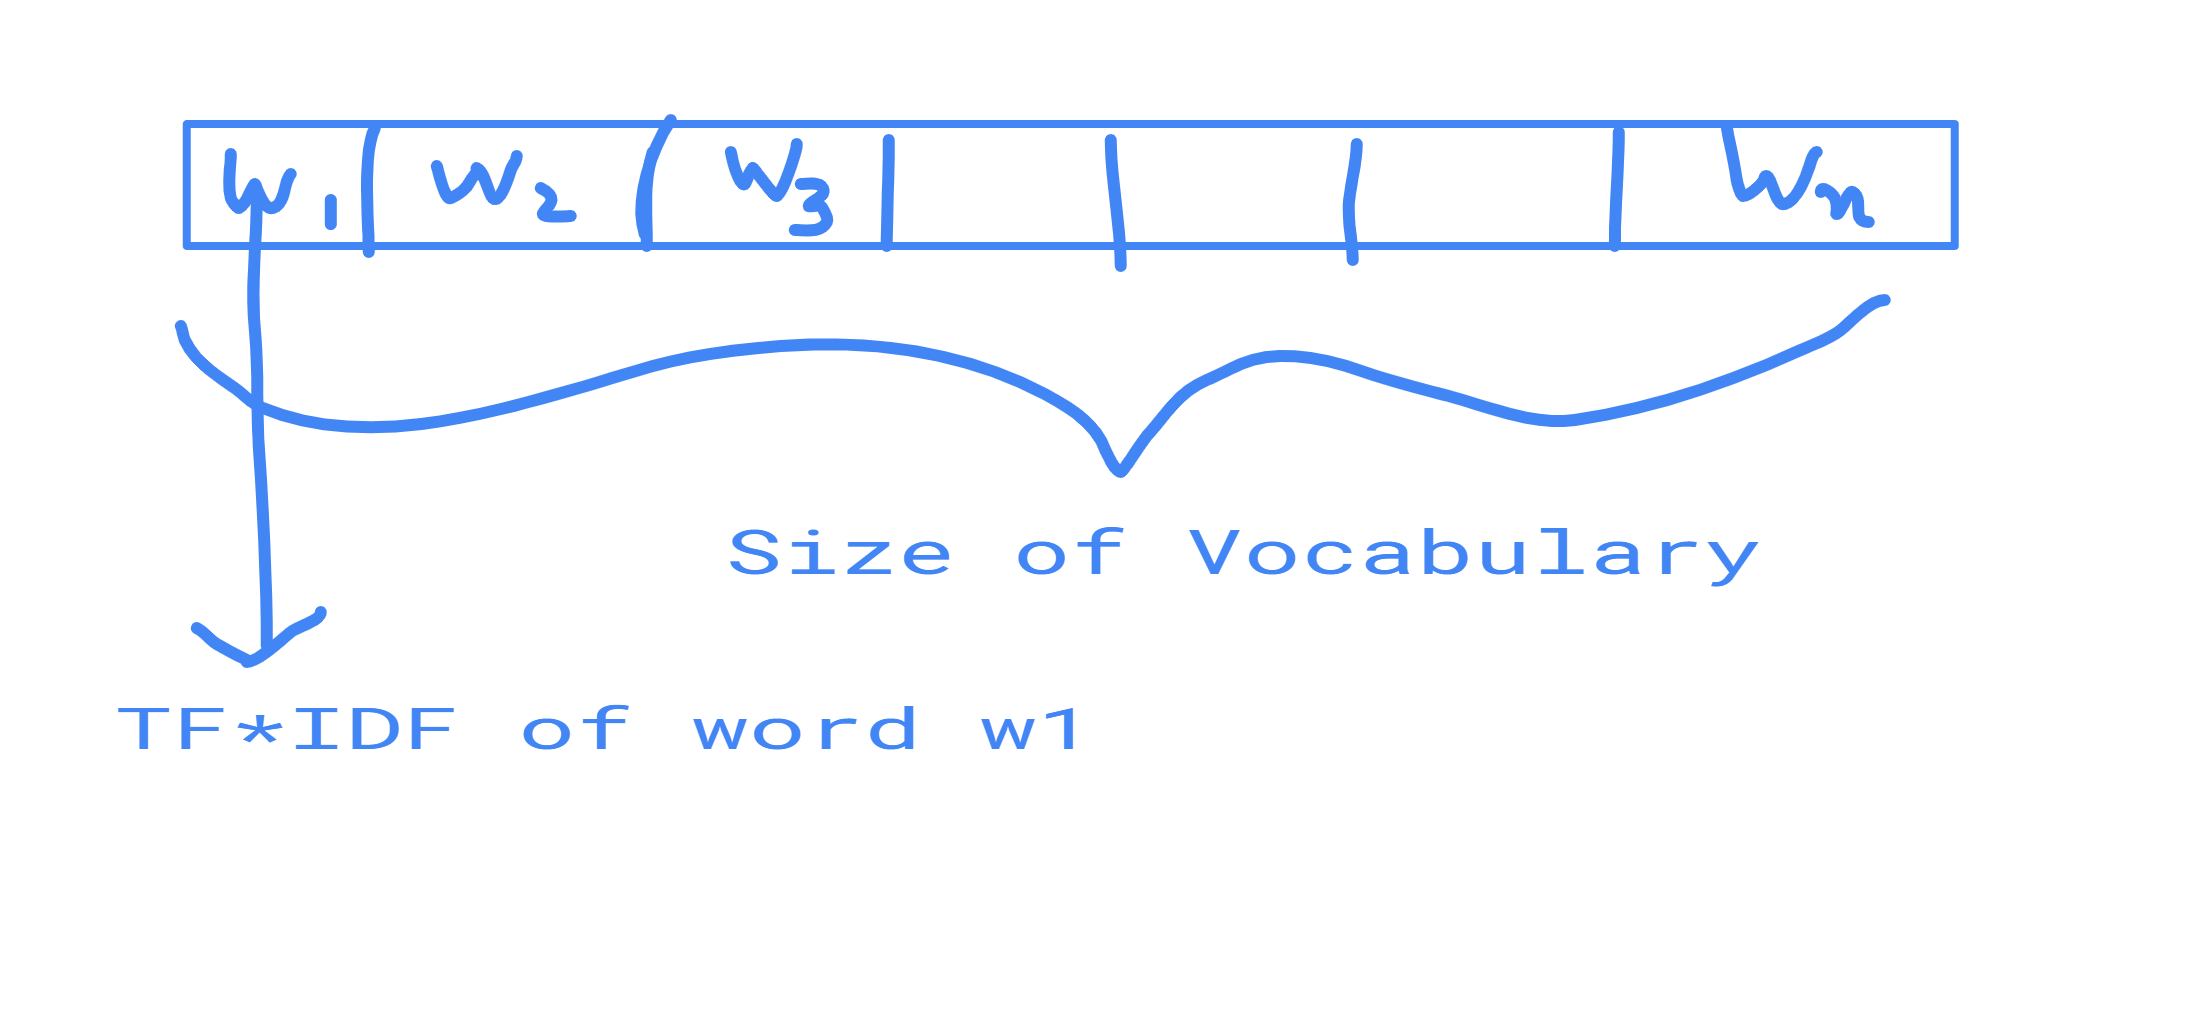

### 4.0 Building TF-IDf Embeddding

In [ ]:
vectorizer = TfidfVectorizer(max_features=500)  ## we are only considering the words that occurs more than 10 times my setting df=10
tfidf = vectorizer.fit(x_train['text'])  ## Note that the fit has to happens only in the train data

x_train_tfidf = tfidf.transform(x_train['text'])
x_test_tfidf = tfidf.transform(x_test['text'])

test_tfidf  = tfidf.transform(test_data['text'])


print("Shape of the train embedded vector is {}".format(x_train_tfidf.shape))
print("Shape of the test embedded vector is {}".format(x_test_tfidf.shape))

print(type(y_train))

### 4.1 TF-IDf + SVM

In [ ]:
parameters = {'kernel':('rbf',), 'C':[1,2,5,10]}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv = 4, scoring = 'f1')
clf.fit(x_train_tfidf, y_train)


In [ ]:
print("Average of the best f1-score in every fold during cross validation = ",clf.best_score_)
print("The best parameters found during k-fold cross validation is = ",clf.best_params_)

#### Now we have found the best hyperparameter for the model. So lets see how our model performs on unseen data. Also we will be building our confusion mastrix using this test only

In [ ]:
y_pred = clf.predict(x_test_tfidf)

In [ ]:
#Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud for this function

def plot_cm(y_true, y_pred, title, figsize=(7,7)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred, "Confusion Matrix on unseen data using TF-IDf + SVM")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred))

#### Conclusion: As we can see from the confusion matrix that our model is predecting class "0" with good confidence but when it comes to class "1" our model is a little confused in predicting this class.

### 4.2 TF-IDf + Random Forest

In [ ]:
## Lets build our hyperparameter search grid
## since we have a large space of hyperparamter we will use randomisedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 4,scoring = 'f1')
rf_random.fit(x_train_tfidf, y_train)

In [ ]:
print("Average of the best f1-score in various folds during cross validation = ",rf_random.best_score_)
print("The best parameters found during k-fold cross validation is = ",rf_random.best_params_)

#### Now we have found the best hyperparameter for the model. So lets see how our model performs on unseen data. Also we will be building our confusion mastrix using this test only

In [ ]:
y_pred = rf_random.predict(x_test_tfidf)

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred, "Confusion Matrix on unseen data using TF-IDf + RandomForest")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred))

#### Conclusion : The performance on unseen data is not good, as it is clear from the f1 score of the test data. 

### 4.3 TF-IDf + XgBoost

In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,10,20,40]
        }

clf = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=10, scoring='f1', cv=4)
clf.fit(x_train_tfidf, y_train)


In [ ]:
print("Average of the best f1-score in various folds during cross validation = ",clf.best_score_)
print("The best parameters found during k-fold cross validation is = ",clf.best_params_)

#### Now we have found the best hyperparameter for the model. So lets see how our model performs on unseen data. Also we will be building our confusion mastrix using this test only

In [ ]:
y_pred = clf.predict(x_test_tfidf)

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred, "Confusion Matrix on unseen data using TF-IDf + XgBoost")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred))

#### Conclusion : XgBoost model slightly performs better than RandomForest

### 4.4 Tf-IDF + Sequential model with LSTM

In [ ]:
model = keras.Sequential()

model.add(layers.LSTM(256, activation='relu', kernel_initializer='he_normal', input_shape=(1,500), return_sequences=True))

model.add(layers.LSTM(100, activation='relu', kernel_initializer='he_normal', return_sequences=True))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary() 

In [ ]:
model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_input = x_train_tfidf.toarray()
model_input = model_input[:, None, :]
model_label =  y_train[:, None]
print(model_input.shape)
history = model.fit(model_input, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)

In [ ]:
test_input = x_test_tfidf.toarray()
test_input = test_input[:, None, :]
y_pred = model.predict(test_input)
y_pred = y_pred.round().astype(int)

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred[:, 0, 0], "Confusion Matrix on unseen data using TF-IDf + Sequential Model With LSTM")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred[:, 0, 0]))

#### F1 score on this model is good and we may get a better result by tuning the hyperparameters but since we have limited data so it is not advised to train deep networks.

## 5. Building Model Using GloVe Embedding

### 5.1 Building the Glove Embedding for text

In [ ]:
## Making a dictionary of the words and their vector representation

embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vectors representing the embedding for the word
    embeddings_index[word] = coefs
f.close()


print('GloVe data loaded')

In [ ]:
glove_words =  set(embeddings_index.keys())

'''
Below is a uliity function that takes sentenes as a input and return the vector representation of the same
Method adopted is similar to average word2vec. Where i am summing up all the vector representation of the words from the glove and 
then taking the average by dividing with the number of words involved
'''

def convert_sen_to_vec(text):
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split():
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    return vector



In [ ]:
glove_train = []  ## this will be of size num_of_train_points*300
glove_test = []   ## this will be of size num_of_test_points*300

for sentence in x_train['text']:
    sen_vec = convert_sen_to_vec(sentence)
    glove_train.append(sen_vec)
    
for sentence in x_test['text']:
    sen_vec = convert_sen_to_vec(sentence)
    glove_test.append(sen_vec)

print(len(glove_train))
print(len(glove_train[0]))

### 5.2 GloVe + SVM

In [ ]:
## setting up the hyperparamter space
parameters = {'kernel':('rbf',), 'C':[1,2,5,10]}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv = 4, scoring = 'f1')
clf.fit(glove_train, y_train)

In [ ]:
print("Average of the best f1-score in every fold during cross validation = ",clf.best_score_)
print("The best parameters found during k-fold cross validation is = ",clf.best_params_)

#### Now we have found the best hyperparameter for the model. So lets see how our model performs on unseen data. Also we will be building our confusion mastrix using this test only

In [ ]:
y_pred = clf.predict(glove_test)

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred, "Confusion Matrix on unseen data using GloVe + SVM")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred))

#### Conclusion : We can see a good jump in F1 score by using GloVe embedding.

### 5.3 GloVe + Random Forest

In [ ]:
## Lets build our hyperparameter search grid
## since we have a large space of hyperparamter we will use randomisedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 4,scoring = 'f1')
rf_random.fit(glove_train, y_train)

In [ ]:
print("Average of the best f1-score in various folds during cross validation = ",rf_random.best_score_)
print("The best parameters found during k-fold cross validation is = ",rf_random.best_params_)

#### Now we have found the best hyperparameter for the model. So lets see how our model performs on unseen data. Also we will be building our confusion mastrix using this test only

In [ ]:
y_pred = rf_random.predict(glove_test)

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred, "Confusion Matrix on unseen data using GloVe + Random Forest")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred))

#### Conclusion : Although the F1 score is good as compared to TF-IDf + Random Forest, but the F1 score is less than GloVe + SVM model

### 5.4 GloVe + XgBoost

In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=150)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4,10,20]
        }

clf = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=5, scoring='f1', cv=4)
clf.fit(np.array(glove_train), y_train)


In [ ]:
print("Average of the best f1-score in various folds during cross validation = ",clf.best_score_)
print("The best parameters found during k-fold cross validation is = ",clf.best_params_)

#### Now we have found the best hyperparameter for the model. So lets see how our model performs on unseen data. Also we will be building our confusion mastrix using this test only

In [ ]:
y_pred = clf.predict(np.array(glove_test))

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred, "Confusion Matrix on unseen data using GloVe + XgBoost")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred))

#### Conclusion: The F1 score of XgBoost roughly matches with SVM 

### 5.5 GloVe + Sequential Model with LSTM

#### We are getting rid of the Embedding layer of the LSTM(We can build the model using the Embedding layer too with trainable = false). Rather we are giving the input after converting our training example into vector format

In [ ]:
model = keras.Sequential()

model.add(layers.LSTM(256, activation='relu', kernel_initializer='he_normal', input_shape=(1,300), return_sequences=True))

model.add(layers.LSTM(100, activation='relu', kernel_initializer='he_normal', return_sequences=True))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary() 

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_input = np.array(glove_train)
model_input = model_input[:, None, :]
model_label =  y_train[:, None]
print(model_input.shape)
history = model.fit(model_input, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.1)

In [ ]:
test_input = np.array(glove_test)
test_input = test_input[:, None, :]
y_pred = model.predict(test_input)
y_pred = y_pred.round().astype(int)

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred[:, 0, 0], "Confusion Matrix on unseen data using GloVe + Sequential Model With LSTM")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred[:, 0, 0]))

#### Conclusion: Even simple Sequential Model on top of GloVe outperforms SVM and XgBoost.

## 6. BERT

### 6.1 Fine Tuned BERT

In [ ]:
# We will use the official tokenization script created by the Google team
# If you are running this on kaggle make sure you turn on the internet of the kaggle notebook (Click on arrow at the top right corner and you will find it)
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import tokenization

In [ ]:
'''
We are preparing out data in such a way that bert model can understand it

We have to give three sequences as input to the BERT

all_tokens : It basically performs the tokenization of the input sentences
all_masks  : This is done to make every input of the same length. We choose the maximum length of the vector and pad other vectors accordingly. We padd them 
             with the help of '0' which tells tells the model not to give attension to this token
segment Ids: This is used when we are giving multiple sentences as the input. Since we are only giving one sentence as the input we set the value of the 
             segment ids as 0 for all the tokens.
             
For more detailed you can visit this terrific blog : jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time
'''

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)



In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
#Setting up the tokenizer

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
train_input = bert_encode(x_train['text'], tokenizer, max_len=160)
test_input = bert_encode(x_test['text'], tokenizer, max_len=160)
submission_test_input = bert_encode(test_data['text'], tokenizer, max_len=160) 

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, y_train,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [ ]:
y_pred = test_pred.round().astype(int)
y_pred.shape

#### Lets print the confusion matrix on the test data and see how the model performed on the unseen data

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred[:, 0], "Confusion Matrix on unseen data using Fine Tuned BERT + Simple Classifier")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred[:, 0]))

### 6.2 SVM on top of Fine Tuned BERT

In [ ]:
#get output of slice layer from model above
cls_layer_model = Model(model.input, outputs=model.get_layer('tf_op_layer_strided_slice').output)

In [ ]:
X_train = cls_layer_model.predict(train_input)
X_test = cls_layer_model.predict(test_input)

In [ ]:
print(X_train.shape)

In [ ]:
parameters = {'kernel':('rbf',), 'C':[2,5,10]}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv = 4, scoring = 'f1')
clf.fit(X_train, y_train)

In [ ]:
print("Average of the best f1-score in every fold during cross validation = ",clf.best_score_)
print("The best parameters found during k-fold cross validation is = ",clf.best_params_)

In [ ]:
y_pred = clf.predict(X_test)

#### Lets print the confusion matrix on the test data and see how the model performed on the unseen data

In [ ]:
#Ploting the confusion matrix
plot_cm(y_test, y_pred, "Confusion Matrix on unseen data using Fine Tuned BERT + SVM")

from sklearn.metrics import f1_score
print("The F1-Score on the test data is = ",f1_score(y_test, y_pred))

## 7. Performing submission

#### I am going to use SVM on top of the Fine Tuned BERT as the model for the prediction

In [ ]:
test_input_for_submission = cls_layer_model.predict(submission_test_input)
y_pred = clf.predict(test_input_for_submission)

submission['target'] = y_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

## If you found the notebook useful then an upvote is highy appreciated. 